# PROJECT TITLE:
Corporation Favorita Store sales -Time series forecasting 

# Business Understanding

## 1. Introduction
This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores.


### 1.1. Objectives
Understand the data: The first objective is to gain insights into the store sales data, including store-specific information, product families, promotions, and sales numbers. This understanding will enable the company to make informed business decisions.

Predict store sales: Develop a reliable time series forecasting model that accurately predicts the unit sales for different product families at various Favorita stores. This will help the company optimize inventory management, plan promotions, and improve overall sales performance.

### 1.2. Methodology
To achieve the objectives, we will follow a structured approach:

Data Exploration: Thoroughly explore the provided datasets to understand the available features, their distributions, and relationships. This step will provide initial insights into the store sales data and help identify any data quality issues.

Data Preparation: Handle missing values, perform feature engineering, and encode categorical variables as necessary. This step may involve techniques like imputation, scaling, and one-hot encoding.

Time Series Analysis: Analyze the temporal aspects of the data, including trends, seasonality, and potential outliers. This analysis will provide a deeper understanding of the underlying patterns in store sales over time.

Model Selection and Training: Select appropriate time series forecasting models and train them using the prepared data. Consider incorporating external factors like promotions, holidays, and oil prices, if available, to enhance the forecasting accuracy.

Model Evaluation: Evaluate the trained models using appropriate metrics, such as mean absolute error (MAE), root mean squared error (RMSE), or mean absolute percentage error (MAPE). Assess the models' performance and identify the most accurate and reliable forecasting model.

Model Deployment and Forecasting: Deploy the chosen model to predict store sales for future time periods, leveraging the provided test dataset. Generate forecasts for the target period and assess the model's ability to capture the sales patterns accurately.

By following this framework, we are going to predict store sales of Corporation Favorita.

## Importation

In [1]:
#Data handling 
import pandas as pd 
import numpy as np
 
from dotenv import dotenv_values 
import pyodbc

#visualization 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#statistical analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


#feature processing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#modelling 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

import warnings

warnings.filterwarnings("ignore")
 

## Data loading 

### Loading data remotely from a SQL server 

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVERNAME")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
connection_string = f"DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

connection = pyodbc.connect(connection_string)

In [3]:
# Query the first table 'oil' in the database
query1 = 'SELECT * FROM dbo.oil'
oil_df = pd.read_sql(query1, connection)
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [4]:
# Query the second table 'holidays_events' in the database
query2 = 'SELECT * FROM dbo.holidays_events'
holidays_events_df = pd.read_sql(query2, connection)
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
# Query the third table 'stores' in the database
query3 = 'SELECT * FROM dbo.stores'
stores_df = pd.read_sql(query3, connection)
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Loading the train and test datasets

In [6]:
train_data= pd.read_csv(r'C:\Users\Said Ahmed\Desktop\personalprojects\train.csv')
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
test_data= pd.read_csv(r'C:\Users\Said Ahmed\Desktop\personalprojects\LP3-Reggression-project\Data\test.csv')
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Loading the transaction dataset

In [9]:
trans_data= pd.read_csv(r'C:\Users\Said Ahmed\Desktop\personalprojects\LP3-Reggression-project\Data\transactions.csv')
trans_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Questions and Hypothesis

## Hypothesis

## Questions
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year?
3. Determine if certain groups of stores sell more products
4. Are sales affected by promotions, oil prices and holidays?


# Exploratory Data Analysis (EDA), Data Preprocessing & Cleaning 

## Data Understanding 
performing an in-depth analysis of the datasets , that is going to help in finding issues with the data and find ways of how to clean and pre-process it.

### STEP 1: Checking the shape of the datasets 

In [10]:
train_data.shape

(3000888, 6)

In [11]:
test_data.shape

(28512, 5)

In [12]:
# Print out the shapes of the other datasets
print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holidays_events_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")
print(f"Transactions Dataset: {trans_data.shape}")

Shapes of Each Dataset:
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)


The train dataset is larger compared to the test dataset, train data is usually large to provide enough data for model training.

The Holiday Events dataset provides information about various holidays and events.

The Oil dataset includes information about the daily price of oil.

The Stores dataset provides details about different stores, such as their locations, types, and clusters.

The Transactions dataset contains information about the number of transactions made at each store on specific dates.

### STEP 2:Checking the column info of the datasets

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


- The "date" column in both datasets of type object. It needs to be converted to a datetime data type for further analysis.

In [15]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

In [16]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.
- The 'dcoilwtico' column has 1,175 non-null values, indicating that there are some missing values in this column.

In [17]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [18]:
holidays_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

### STEP 3: Change the 'date' columns to the correct datetime format

In [19]:
# Train dataset
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [20]:
# Test dataset
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [21]:
# Holiday Events dataset
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
holidays_events_df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 350 entries, 0 to 349
Series name: date
Non-Null Count  Dtype         
--------------  -----         
350 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.9 KB


In [22]:
# Oil dataset
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df['date'].dtype

dtype('<M8[ns]')

In [23]:
# Transactions dataset
trans_data['date'] = pd.to_datetime(trans_data['date'])
trans_data['date'].dtype

dtype('<M8[ns]')

The columns are now formatted correctly 

### STEP 4: checking for missing values in the datasets

In [24]:
oil_df.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [25]:
stores_df.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [26]:
holidays_events_df.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [27]:
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [28]:
test_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [29]:
trans_data.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

- Only the oil dataset has 43 missing values on the 'dicoilwtico' column 

##### Fill missing values in the 'dcoilwtico' (daily crude oil prices) column using backfill strategy

In [30]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='backfill')

##### Check if the missing values have been handled

In [31]:
oil_df.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

### STEP 5: Merging The Train Dataset with the Stores, Transactions, Holiday Events and Oil Dataset

In [32]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_data with stores_df based on 'store_nbr' column
merged_df1 = train_data.merge(stores_df, on='store_nbr', how='inner')

# Merge merged_df1 with trans_data based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(trans_data, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(holidays_events_df, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_data = merged_df3.merge(oil_df, on='date', how='inner')

# View the first five rows of the merged dataset
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


We have used an inner merge to combine the datasets to ensures that we are working with a unified dataset that contains only the relevant information for the dates common to all datasets, facilitating a cleaner and more consistent analysis for time series forecasting.helps in avoiding having rows with missing values or mismatched timestamps in the final dataset.

Also an inner merge ensures that all the data points in the resulting dataset share the same timestamps, providing a unified time index for analysis and modeling.

In [33]:
# Check the column information of the merged dataset
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

- It is seen that we have no null values in the merged data.
- The merged dataset consists of 322,047 non-null observations.
- Two columns have been renamed as a result of the merging, type_x and type_y.

In [34]:
# Renaming the columns with the approapriate names
merged_data = merged_data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [35]:
# Generate summary statistics 
merged_data.describe().T

,count,mean,min,25%,50%,75%,max,std
id,322047.0,1682979.459576,561.0,1010616.5,1842406.0,2209555.5,3000887.0,786249.257767
date,322047,2015-08-04 23:49:57.971103488,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095
cluster,322047.0,8.531202,1.0,4.0,9.0,13.0,17.0,4.713809
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
dcoilwtico,322047.0,63.636381,27.959999,44.880001,51.98,94.089996,107.949997,24.855753


### STEP 6: Check for duplicated values in the merged dataset

In [36]:
duplicates=merged_data.duplicated().sum()
duplicates

0

- There are no duplicates found

### STEP 7: Saving the merged dataset to a csv file to be used for visualization.

In [37]:
merged_data.to_csv('Visualization_Data.csv', index=False)
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


## Univariate, Multivariate and Bivariate Analysis

### 1: Univariate
Univariate analysis is useful for gaining an initial understanding of the characteristics of a single variable before exploring relationships with other variables in multivariate analysis

#### Distribution of sales

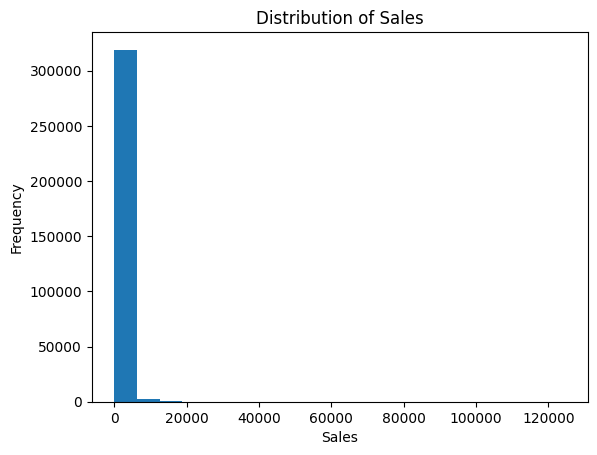

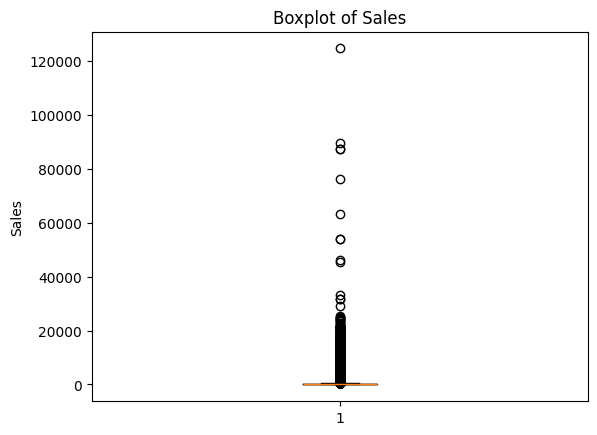

In [38]:
# Histogram
plt.hist(merged_data['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Boxplot
plt.boxplot(merged_data['sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()

The histogram shows the frequency distribution of sales values. It reveals that the majority of sales fall within a specific range, represented by the peak in the histogram. However, there are also instances of higher sales values, leading to a right-skewed distribution. This skewness suggests that there are relatively fewer occurrences of very high sales, while the majority of sales are concentrated around lower values. The boxplot further confirms the presence of outliers in the data, as indicated by the points beyond the whiskers.

The presence of outliers, as indicated by points beyond the whiskers in the boxplot, signifies instances of very high sales values that deviate from the norm.
From a business perspective, these outliers may represent significant transactions, strategic partnerships, or key clients. Understanding and analyzing these high-value sales can inform business decisions, such as targeting similar clients, optimizing marketing efforts, or adjusting product/service offerings.

#### Distribution of transactions

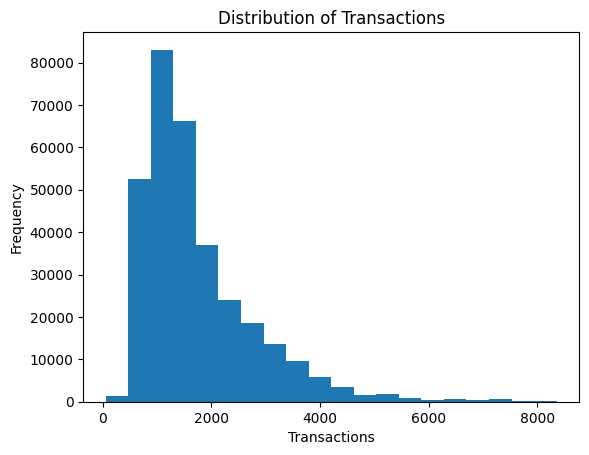

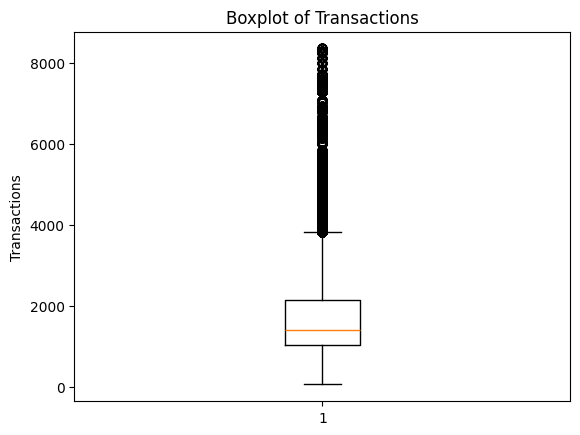

In [39]:
# Histogram
plt.hist(merged_data['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show()

# Boxplot
plt.boxplot(merged_data['transactions'])
plt.ylabel('Transactions')
plt.title('Boxplot of Transactions')
plt.show()

The histogram provides insights into the distribution of transactions in the dataset. The shape of the histogram indicates that the majority of transactions fall into a specific range, which is evident from the high frequency observed on the left side of the histogram. As the transactions increase, the frequency gradually decreases, forming a right-skewed distribution. This suggests that there are relatively fewer instances of high transaction volumes. Overall, the histogram highlights the presence of a cluster of transactions with a lower frequency, indicating a pattern in the data.

#### Distribution of daily oil prices

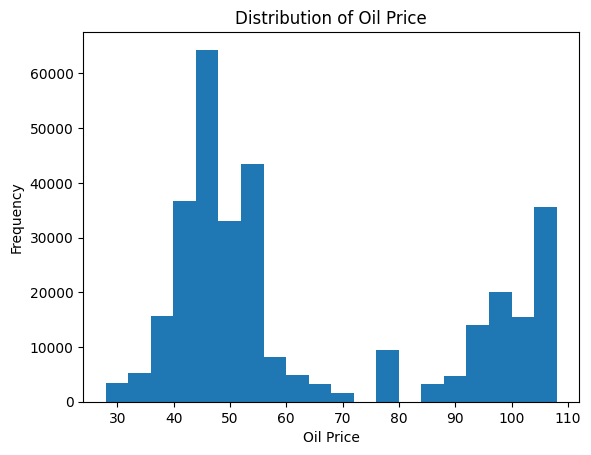

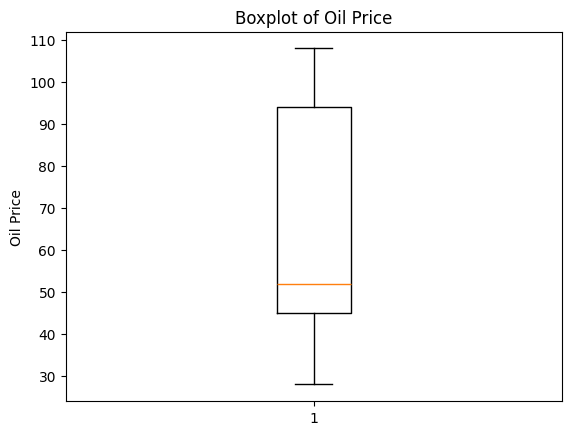

In [40]:
# Histogram
plt.hist(merged_data['dcoilwtico'], bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show()

# Boxplot
plt.boxplot(merged_data['dcoilwtico'])
plt.ylabel('Oil Price')
plt.title('Boxplot of Oil Price')
plt.show()

The histogram and boxplot of the 'dcoilwtico' variable reveal insights into its distribution. The histogram displays the frequency distribution of oil prices, indicating the number of occurrences for each price range.
The prices are not evenly distributed across a range ,there are clusters/peaks, indicating specific price levels that occur more frequently.

### 2: Bivariate

#### Trend of sales over time

In [41]:
# Group the data by date and calculate the total sales
daily_sales = merged_data.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

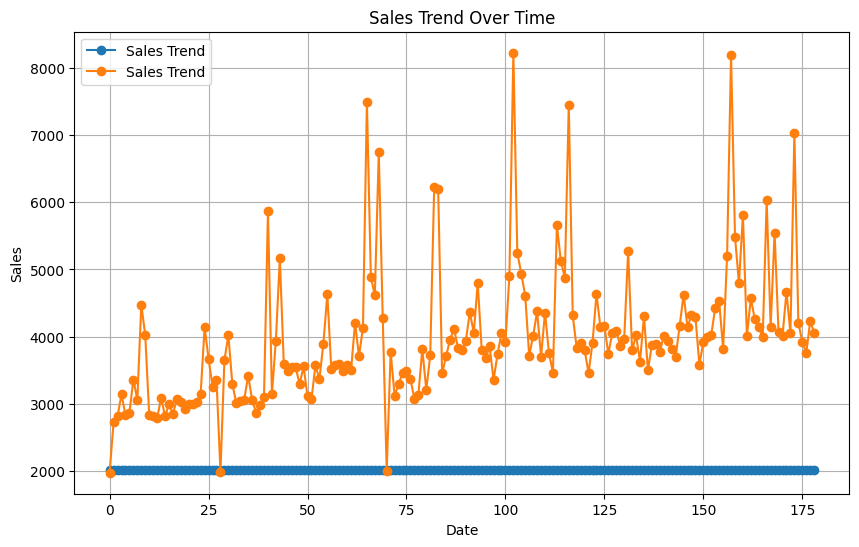

In [42]:
daily_sales = merged_data.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(daily_sales, label='Sales Trend', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Over Time')
plt.grid(True)
plt.legend()
plt.show()

The plot shows the trend of sales over time. From the graph, we can observe that the sales exhibit some variations and fluctuations over time. There are periods of both high and low sales, indicating potential seasonality or other factors affecting sales patterns.

#### Trend of crude oil prices

In [43]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.
fig = px.line(oil_df, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

We can see that oil prices suffered a collapse towards the end of 2014 and have not recovered. In fact despite some volatility, oil prices are at the same level as they were in the beginning of 2015. As a result of this we may see a significant shift in store sales around late 2014. Looking at the unit sales data, this is not readily apparent. Although sales do appear to drop off in the early part of 2015, in late 2014 they are rising. Also, to add oil price drop doesn't seems to have any impact on the sales, as it was seen from the sales plot, there was no relation between oil price dropping on the sales, so we can say that this feature or data is of no importance to us and will not be considered during modelling.

### 3: Multivariate

#### Correlation matrix of the numerical variables

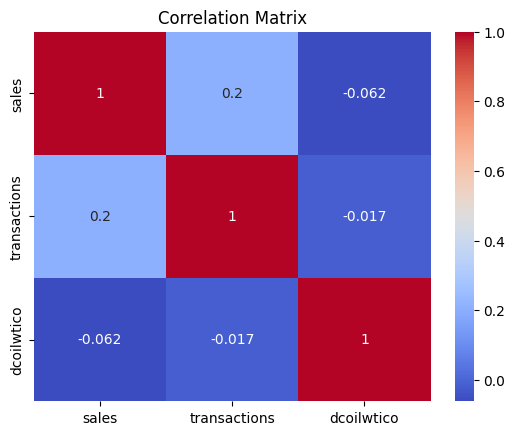

In [44]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_data[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- Sales and Transactions:

There is a weak positive correlation of approximately 0.200 between "Sales" and "Transactions." This suggests that there is a slight positive relationship between the number of transactions and the sales. It implies that when the number of transactions increases, there is a tendency for sales to increase as well, although the correlation is not very strong.

- Sales and Dcoilwito (Oil Prices):

There is a weak negative correlation of approximately -0.062 between "Sales" and "Dcoilwito" (Oil Prices). This indicates a slight negative relationship between sales and oil prices. It suggests that as oil prices increase, there is a tendency for sales to decrease slightly, though the correlation is not significant.

- Transactions and Dcoilwito (Oil Prices):

There is a very weak negative correlation of approximately -0.017 between "Transactions" and "Dcoilwito" (Oil Prices). This suggests that there is almost no relationship between the number of transactions and oil prices. It indicates that fluctuations in oil prices do not have a significant impact on the number of transactions.


#### Scatter plot matrix for numerical variables 

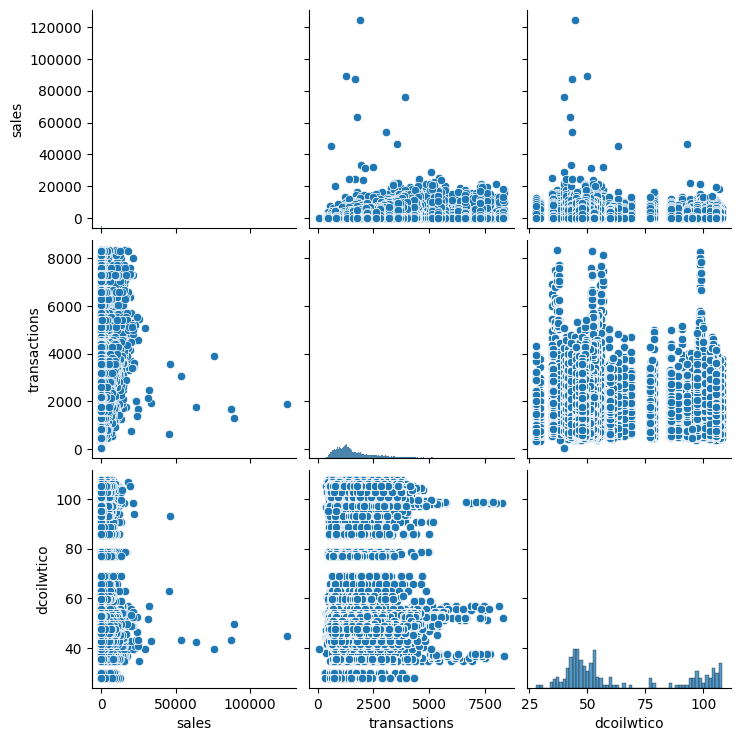

In [45]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Plot scatter plot matrix
sns.pairplot(merged_data[numerical_vars])
plt.show()

# Stationarity Test

Stationarity implies that the statistical properties of the time series, such as mean and variance, remain constant over time. In this case, the ADF test was conducted on the 'sales' data from the 'merged_data' dataset. To perform the stationarity test, we will use the Augmented Dickey-Fuller (ADF) test commonly used to check for stationarity in a time series.

In [46]:
# # Statistical Test of the 'sales' column in the merged_df using Adfuller
# sales_data = merged_data['sales']

# # Perform ADF test
# result = adfuller(sales_data)

# # Extract the test statistics and p-value from the result
# test_statistic = result[0]
# p_value = result[1]
# critical_values = result[4]

# # Print the test statistics and critical values
# print(f"ADF Test Statistics: {test_statistic}")
# print(f"P-value: {p_value}")
# print("Critical Values:")
# for key, value in critical_values.items():
#     print(f"   {key}: {value}")

# # Check the p-value against a significance level (e.g., 0.05)
# if p_value <= 0.05:
#     print("Reject the null hypothesis: The sales data is stationary.")
# else:
#     print("Fail to reject the null hypothesis: The sales data is non-stationary.")

### Hypothesis Testing

### Answering Questions

#### 1. Is the train dataset complete (has all the required dates)?

In [47]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


#### 2. Which dates have the lowest and highest sales for each year?

In [48]:
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['year'] = merged_data['date'].dt.year

lowest_sales_dates = merged_data.groupby('year')['date'].min()
highest_sales_dates = merged_data.groupby('year')['date'].max()

print("Dates with the lowest sales for each year:\n", lowest_sales_dates)
print("="*50)
print("Dates with the highest sales for each year:\n", highest_sales_dates)

Dates with the lowest sales for each year:
 year
2013   2013-01-01
2014   2014-01-01
2015   2015-01-01
2016   2016-02-08
2017   2017-01-02
Name: date, dtype: datetime64[ns]
Dates with the highest sales for each year:
 year
2013   2013-12-31
2014   2014-12-31
2015   2015-12-31
2016   2016-12-26
2017   2017-08-15
Name: date, dtype: datetime64[ns]


#### 3. Determine if certain groups of stores sell more products

In [49]:
# Group by cluster and calculate the average sales
average_sales_by_cluster = merged_data.groupby('cluster')['sales'].mean()

# Group by city and calculate the average sales
average_sales_by_city = merged_data.groupby('city')['sales'].mean()

# Group by state and calculate the average sales
average_sales_by_state = merged_data.groupby('state')['sales'].mean()

# Group by store type and calculate the average sales
average_sales_by_store_type = merged_data.groupby('store_type')['sales'].mean()

# Set the number of bars in each plot
num_bars = len(average_sales_by_cluster)

# Generate the colors using the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))

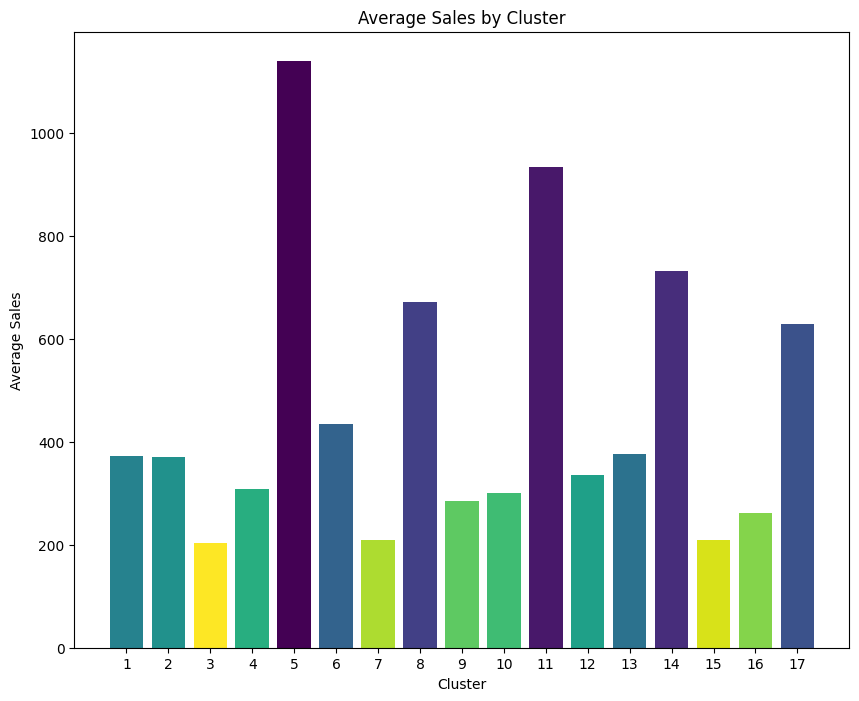

In [50]:
# Sort the data by average sales in descending order
average_sales_by_cluster = average_sales_by_cluster.sort_values(ascending=False)

# Plot the average sales by cluster
plt.figure(figsize=(10, 8))
plt.bar(average_sales_by_cluster.index, average_sales_by_cluster.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.title('Average Sales by Cluster')

# Set the x-tick labels as integers
plt.xticks(range(1, len(average_sales_by_cluster.index) + 1))
plt.show()

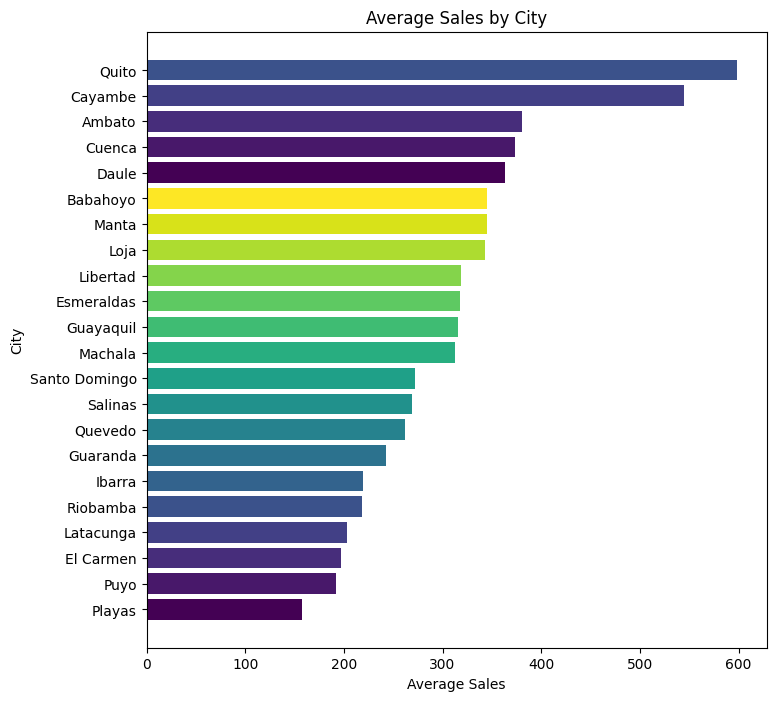

In [51]:
# Sort the data by average sales in descending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

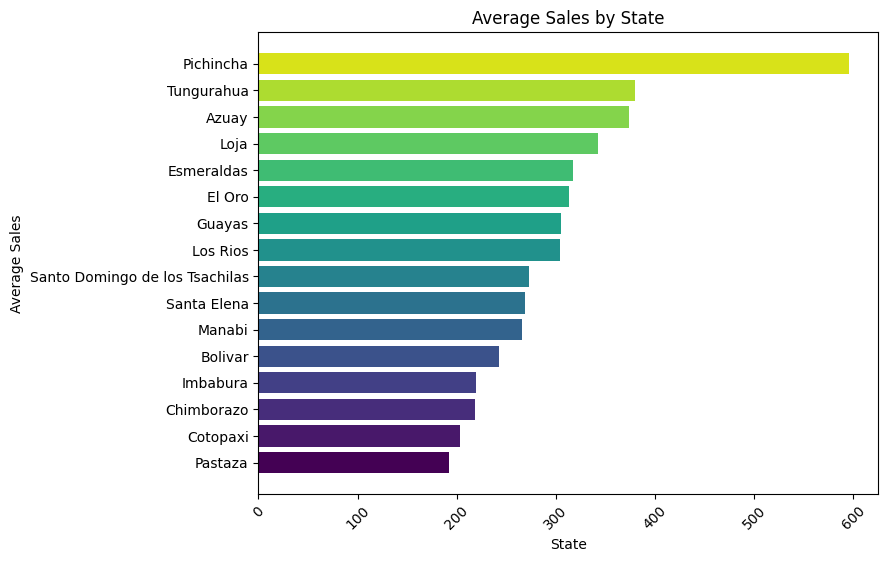

In [52]:
# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 6))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('State')
plt.ylabel('Average Sales')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

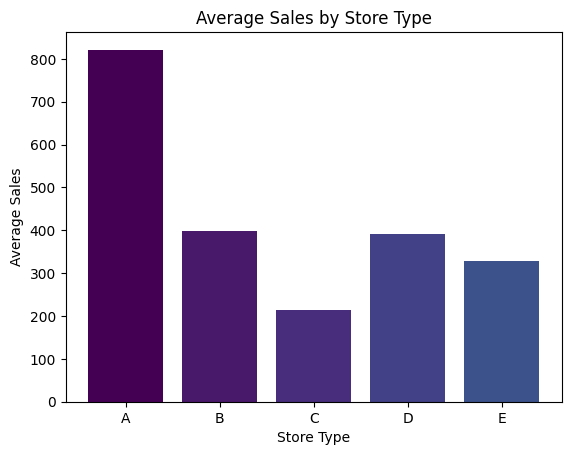

In [53]:
# Plot the average sales by store type
plt.bar(average_sales_by_store_type.index, average_sales_by_store_type.values, color=colors)
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Type')
plt.show()

#### 4. Are sales affected by promotions, oil prices and holidays?

In [54]:
# Calculate correlations between sales and promotions, oil prices, holidays
corr_sales_promotions = merged_data['sales'].corr(merged_data['onpromotion'])
corr_sales_oil = merged_data['sales'].corr(merged_data['dcoilwtico'])
corr_sales_holidays = merged_data['sales'].corr(merged_data['holiday_type'] == 'Holiday')

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

Correlation between Sales and Promotions: 0.4180289197242383
Correlation between Sales and Oil Prices: -0.06150915261069542
Correlation between Sales and Holidays: -0.03706892930251642


- Promotions:
There is a positive correlation of approximately 0.42 between sales and promotions. This suggests that promotions have a moderate positive impact on sales. When promotions are running, there is an increased likelihood of higher sales.


- Oil Prices:
There is a weak negative correlation of approximately -0.06 between sales and oil prices. This indicates that there is a slight negative relationship between sales and oil prices. However, the correlation is close to zero, suggesting that oil prices have minimal impact on sales.


- Holidays:
There is a very weak negative correlation of approximately -0.04 between sales and holidays. This indicates that there is almost no relationship between sales and holidays. Holidays do not seem to have a significant impact on sales.
These insights suggest that promotions have a relatively stronger influence on sales compared to oil prices and holidays. While promotions positively impact sales, oil prices and holidays show minimal or no relationship with sales.

# Feature Enginering

## Train Dataset

### Extracting Date Components (Day, Month, Year and Day of The Week).

In [55]:
# Extracting Date Components
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['day'] = merged_data['date'].dt.day
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002,2013,2,11


### Dropping Unneccessary Columns in The Merged and Test Datasets as it will not needed for our analysis

In [56]:
columns_to_drop = ['date','id', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
merged_data = merged_data.drop(columns=columns_to_drop)

merged_data.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,1,AUTOMOTIVE,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
1,1,BABY CARE,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
2,1,BEAUTY,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
3,1,BEVERAGES,172.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
4,1,BOOKS,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11


### Product Categorization Based on Families

In [57]:
unique_families = merged_data['family'].unique()
unique_families

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [58]:
# Define the category lists for each product category
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
merged_data['family'] = np.where(merged_data['family'].isin(food_families), 'FOODS', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(home_families), 'HOME', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(clothing_families), 'CLOTHING', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(grocery_families), 'GROCERY', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(stationery_families), 'STATIONERY', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(cleaning_families), 'CLEANING', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(hardware_families), 'HARDWARE', merged_data['family'])

# Print the updated DataFrame
merged_data.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,1,AUTOMOTIVE,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
1,1,CLEANING,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
2,1,BEAUTY,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
3,1,FOODS,172.0,0,Quito,13,396,Holiday,97.010002,2013,2,11
4,1,STATIONERY,0.0,0,Quito,13,396,Holiday,97.010002,2013,2,11


### Feature Scaling

In [59]:
# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
merged_data[num_cols] = scaler.fit_transform(merged_data[num_cols])

# Display the updated dataframe
merged_data.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,1,AUTOMOTIVE,-0.325920,0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11
1,1,CLEANING,-0.325920,0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11
2,1,BEAUTY,-0.325920,0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11
3,1,FOODS,-0.187976,0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11
4,1,STATIONERY,-0.325920,0,Quito,13,-1.273993,Holiday,1.342694,2013,2,11


Feature scaling is a preprocessing technique used to standardize or normalize the range of independent variables or features of a dataset. The goal of feature scaling is to bring all features to a similar scale, preventing some features from dominating others during the modeling process. This is particularly important for algorithms that are sensitive to the scale of input features.

### Encoding The Categorical Variables

In [60]:
# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type"]

# Perform one-hot encoding
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(merged_data[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_data_encoded = pd.DataFrame(encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_data_encoded = pd.concat([merged_data, merged_data_encoded], axis=1)

# Drop the original categorical columns
merged_data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_data_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,family_AUTOMOTIVE,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,1,-0.325920,0,13,-1.273993,1.342694,2013,2,11,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,-0.325920,0,13,-1.273993,1.342694,2013,2,11,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.325920,0,13,-1.273993,1.342694,2013,2,11,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,-0.187976,0,13,-1.273993,1.342694,2013,2,11,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,-0.325920,0,13,-1.273993,1.342694,2013,2,11,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Test_df

In [61]:
# Extracting Date Components
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data.head()

,id,date,store_nbr,family,onpromotion,year,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16


In [62]:
# Dropping Unnecessary Columns
columns_to_drop = ['date', 'id']
test_data = test_data.drop(columns=columns_to_drop)
test_data.head()

,store_nbr,family,onpromotion,year,month,day
0,1,AUTOMOTIVE,0,2017,8,16
1,1,BABY CARE,0,2017,8,16
2,1,BEAUTY,2,2017,8,16
3,1,BEVERAGES,20,2017,8,16
4,1,BOOKS,0,2017,8,16


In [63]:
# Product Categorization Based on Families
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI', 'PRODUCE', 'DAIRY', 'POULTRY', 'EGGS', 'SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES', 'SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE', 'PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS', 'HARDWARE']

test_data['family'] = np.where(test_data['family'].isin(food_families), 'FOODS', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(home_families), 'HOME', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(clothing_families), 'CLOTHING', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(grocery_families), 'GROCERY', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(stationery_families), 'STATIONERY', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(cleaning_families), 'CLEANING', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(hardware_families), 'HARDWARE', test_data['family'])


In [64]:
# Encoding The Categorical Variables
# List of categorical columns to encode
categorical_columns = ["family"]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Perform one-hot encoding on the 'test_data' data for the specified categorical columns
encoded_data = encoder.fit_transform(test_data[categorical_columns])

# Get the column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the one-hot encoded data and corresponding column names
test_data_encoded = pd.DataFrame(encoded_data.toarray(), columns=column_names)

# Concatenate the original 'test_df' with the one-hot encoded data
test_data_encoded = pd.concat([test_data, test_data_encoded], axis=1)

# Drop the original categorical columns since they have been encoded
test_data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the updated 'test_df_encoded' DataFrame
test_data_encoded.head()

,store_nbr,onpromotion,year,month,day,family_AUTOMOTIVE,family_BEAUTY,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_GROCERY,family_HARDWARE,family_HOME,family_LADIESWEAR,family_LAWN AND GARDEN,"family_LIQUOR,WINE,BEER",family_PET SUPPLIES,family_STATIONERY
0,1,0,2017,8,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2017,8,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2017,8,16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,20,2017,8,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,2017,8,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modeling

## Data Splitting

In [65]:
train_set = merged_data_encoded.loc[merged_data_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = merged_data_encoded.loc[merged_data_encoded['year'] == 2017]

In [66]:
train_set.shape

(284889, 50)

In [67]:
eval_set.shape

(37158, 50)

### split data into training and evaluation

In [68]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [69]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

## Model 1. Linear Regression

In [70]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

# Calculate metrics
# Calculate Mean Squared Error (MSE)
lr_mse = mean_squared_error(y_eval, lr_predictions)

# Calculate Mean Absolute Error (MAE)
lr_mae = mean_absolute_error(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae]}).round(2)

# Print the results_lr dataframe
results_lr

,Model,RMSLE,RMSE,MSE,MAE
0,Linear Regression,0.27,0.84,0.71,0.37


## Model 2. ARIMA (AutoRegressive Integrated Moving Average)

In [71]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
results_arima

,Model,RMSLE,RMSE,MSE,MAE
0,ARIMA,0.45,1.09,1.19,0.5


## Model 3. Random Forest Regression

In [72]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)

# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)

# Print the results_rf dataframe
results_rf

,Model,RMSLE,RMSE,MSE,MAE
0,Random Forest,0.23,0.7,0.49,0.25


- RMSLE (Root Mean Squared Logarithmic Error):
        Definition: RMSLE is a metric that measures the ratio between the logarithm of the predicted and actual values. It is particularly useful when the target variable has a wide range of values.
        Interpretation: A lower RMSLE indicates better model performance. It penalizes underestimation and overestimation equally. RMSLE is often preferred when the target variable has a skewed distribution.

- RMSE (Root Mean Squared Error):
        Definition: RMSE is a standard metric that measures the average magnitude of the errors between predicted and actual values. It is the square root of the mean squared differences.
        Interpretation: Like RMSLE, a lower RMSE signifies better performance. It penalizes larger errors more heavily than smaller errors. RMSE is sensitive to outliers and tends to be influenced by large errors.

- MSE (Mean Squared Error):
        Definition: MSE is the mean of the squared differences between predicted and actual values. It measures the average squared deviation of predictions from the true values.
        Interpretation: Similar to RMSE, lower MSE values are indicative of better model performance. MSE has the advantage of being in the same unit as the squared target variable, making it easy to interpret.

- MAE (Mean Absolute Error):
        Definition: MAE is the mean of the absolute differences between predicted and actual values. It measures the average magnitude of errors without considering their direction.
        Interpretation: Lower MAE values indicate better model performance. MAE is less sensitive to outliers compared to RMSE, making it a robust metric. It is often preferred when outliers are present and their impact should be minimized.



These results indicate the performance of each model in terms of different metrics. Lower values of RMSLE, RMSE, MSE, and MAE indicate better model performance. Based on these results, the Random Forest appear to perform better than the Linear Regression, ARIMA models in terms of the provided metrics.


## Hyperparameter Tuning

In [75]:
# Define the parameter grid for tuning the random forest model
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                      n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the data
random_search_rf.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_

# Make predictions using the best model
best_rf_predictions = best_rf_model.predict(X_eval)

# Calculate metrics for the best model
best_rf_mse = mean_squared_error(y_eval, best_rf_predictions)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_mae = mean_absolute_error(y_eval, best_rf_predictions)

# Apply absolute value to both predicted and target values
abs_best_rf_predictions = np.abs(best_rf_predictions)
abs_y_eval = np.abs(y_eval)

# Calculate RMSLE using the absolute values
best_rf_rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_best_rf_predictions))

# Create a DataFrame to store results for the best Random Forest model
best_results_rf = pd.DataFrame({'Model': ['Best Random Forest'],
                                'RMSLE': [best_rf_rmsle],
                                'RMSE': [best_rf_rmse],
                                'MSE': [best_rf_mse],
                                'MAE': [best_rf_mae]}).round(2)

# Print the best_results_rf dataframe
best_results_rf

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# # Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# # Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [74]:
# Print the best parameters
print("Best Parameters for Random Forest Model:")
print(best_rf_params)

Best Parameters for Random Forest Model:


NameError: name 'best_rf_params' is not defined

## Saving the Best RF Model

In [ ]:
# Define the key components
key_components = {
    'model': best_rf_model, 
    'best_params': best_rf_params,
    'best_score': best_rf_rmsle
}

# Save the key components in a file using pickle
with open('best_rf_model_components.pkl', 'wb') as file:
    pickle.dump(key_components, file)